### 📂 PyTorch File Structure

In [95]:
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import Module,Linear,Conv2d,CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [96]:
training_data=datasets.FashionMNIST(root='data',train=True,transform=ToTensor(),download=True)

# root is the path where the train/test data is stored,

# train specifies training or test dataset,

# download=True downloads the data from the internet if it’s not available at root.

# transform and target_transform specify the feature and label transformations

In [97]:
test_data=datasets.FashionMNIST(root='data',train=False,transform=ToTensor(),download=True)

In [98]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [99]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

    DataLoader is a utility that helps load and batch datasets for training or evaluation.
    It handles tasks like shuffling, batching, and parallel data loading, making it easier to iterate over datasets during training.
    Example usage: If you have a dataset of images, DataLoader allows you to load small batches of images at a time instead of loading the entire dataset into memory.
     

In [100]:
train_dataloader=DataLoader(batch_size=64,dataset=training_data)
test_dataloader=DataLoader(batch_size=64,dataset=test_data)

In [101]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


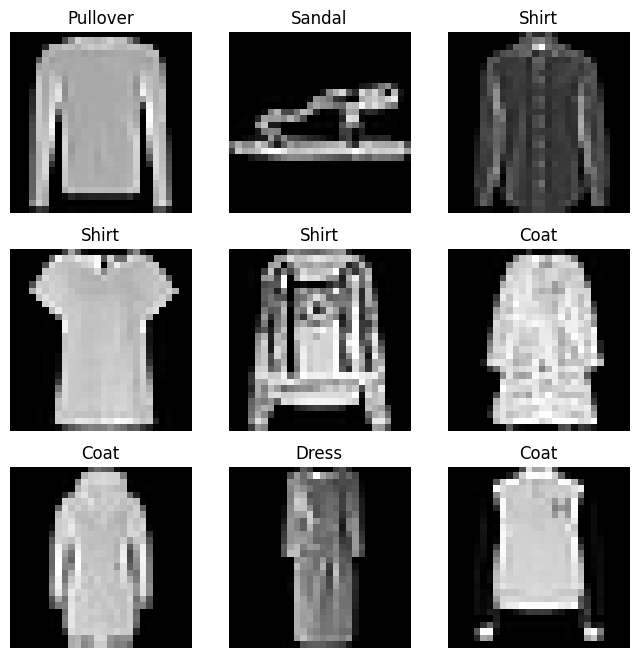

In [102]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Create models

In [103]:
class network(nn.Module):
    def __init__(self): #Constructor method that initializes the layers of the network.
        super().__init__() #Calls the constructor of Module, allowing PyTorch to track layers and parameters.
        self.flatten=nn.Flatten() #Flattens a 2D image (28×28) into a 1D vector (784 values).
        self.linear=nn.Sequential(
            nn.Linear(28*28,64), #First Linear(28*28, 512): Takes 784 input features (28×28 pixels) and maps them to 64 
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10) #Final Linear(32, 10): Maps 32 neurons to 10 output neurons (for 10 classes: 0-9 digits).
        )

    def forward(self,x): #Defines how data flows through the network.
        x=self.flatten(x) #converts 28×28 images into a flat 1D tensor.
        logits=self.linear(x) #Passes the flattened input through the stacked layers.
        return logits  #Returns logits, which are raw scores (before applying softmax).
model=network()
print(model)

network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


#### Optimizing the Model Parameters

In [104]:
loss_func=nn.CrossEntropyLoss() 
#Defines the loss function used for classification tasks.
#This combines Softmax + Negative Log-Likelihood Loss in one step.

opt=torch.optim.SGD(model.parameters(),lr=0.001) 
# Uses Stochastic Gradient Descent (SGD) for optimization.
# model.parameters() → Passes all trainable parameters of the model to the optimizer.
# lr=1e-3 (0.001) → Sets the learning rate to 0.001

In [105]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [106]:
def train (dataloadser , mdoel,loss_func,opt):
    size=len(dataloadser.dataset)
    model.train()
    for batch , (X,y) in enumerate(dataloadser): 
        # Dataloader automatically loads a batch of samples from the dataset.
        # batch is the index of the current batch.
        # X contains a batch of input data (e.g., 64 images from MNIST).
        # y contains the corresponding labels
        
        pred=model(X) #Forward pass (input X through the model)
        loss=loss_func(pred,y) #Computes how far predictions are from the true labels

    loss.backward() 
    # Performs backpropagation, computing gradients for all model parameters.
    # Uses Automatic Differentiation (Autograd) in PyTorch.
    # Stores gradients in parameter.grad (used in optimizer step).
    
    opt.step()
    #Uses computed gradients to update model parameters.
    # For SGD (Stochastic Gradient Descent):
    # θ = θ - lr * gradient
    # θ = Model parameters (weights & biases).
    # lr = Learning rate (1e-3 here).
    # gradient = Slope of loss function w.r.t. parameters.
    
    opt.zero_grad() 
    # Gradients accumulate by default in PyTorch (instead of overwriting).
    # Without zero_grad(), gradients from previous batches add up.
    # This would result in incorrect updates.
    
    if batch % 100 ==0:
        loss,current=loss.item(),(batch+1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [107]:
def test(dataloader,model,loss_func):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    
    model.eval()
    # Switches the model to evaluation mode (turns off dropout & batch normalization).
    # Ensures stable performance during testing.
    
    test_loss,correct=0,0 #Initializes loss & correct predictions count.
    
    with torch.no_grad():
        # Disables gradient tracking to reduce memory usage & speed up computation
        # Since we don’t update model weights in testing, gradients are not needed.
        
        for X,y in dataloader:
            pred=model(X)
            test_loss +=loss_func(pred,y).item()
            correct +=(pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /=num_batches #Averages total loss over all batches.

    correct /= size #Computes the fraction of correct predictions.
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [108]:
epochs=50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader,model,loss_func,opt)
    test(test_dataloader,model,loss_func)
print("Done!!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 2.316048 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 2.315951 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.315854 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.315758 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.315662 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.315565 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.315469 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.315373 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.315277 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.315183 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 13.0%, Avg los

#### Saving Models

In [110]:
torch.save(model.state_dict(),"model.pth")

In [112]:
model=network()
model.load_state_dict(torch.load("model.pth",weights_only=True))

<All keys matched successfully>

In [113]:
model

network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [126]:
#use this model to make predictions

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Bag", Actual: "Ankle boot"


In [128]:
X = torch.rand(1, 28, 28)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6])


In [129]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


Layer: linear.0.weight | Size: torch.Size([64, 784]) | Values : tensor([[ 1.8002e-02,  1.5766e-02, -1.9723e-02,  ..., -5.2397e-03,
          3.1212e-02,  2.8276e-03],
        [-2.7929e-05, -4.3428e-03,  6.6941e-04,  ..., -2.2708e-03,
          2.0093e-02, -1.5591e-02]], grad_fn=<SliceBackward0>) 

Layer: linear.0.bias | Size: torch.Size([64]) | Values : tensor([ 0.0229, -0.0217], grad_fn=<SliceBackward0>) 

Layer: linear.2.weight | Size: torch.Size([32, 64]) | Values : tensor([[-0.0483, -0.0520, -0.0023,  0.0112, -0.1182,  0.0604,  0.1185, -0.0505,
          0.0380, -0.0149, -0.0955, -0.0229,  0.0159,  0.1229,  0.1026,  0.0921,
          0.0602,  0.0735, -0.0821, -0.0583, -0